In [136]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys 
from skimage import data, io, filters
import configparser
import pandas as pd 
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from matplotlib import cycler
from os.path import join as oj
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import pickle as pkl
from sklearn.preprocessing import StandardScaler,MinMaxScaler
sys.path.insert(0, "../src")

from torch.utils.data import DataLoader, TensorDataset
import my_data
from utils.dice_score import dice_loss
from evaluate import evaluate,random_cost,uncertainty_cost
from unet import UNet
from skimage import io
from evaluate import uncertainty_cost
from predict import predict_img
import seaborn as sns
import pickle as pkl
pd.set_option('display.float_format', lambda x: '%.2f' % x)
cuda = False # torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
config = configparser.ConfigParser()
config.read('../config.ini');
data_path =config['DATASET']['data_path'] 
fig_path =config['PATHS']['figure_path'] 

progress_path =config['PATHS']['progress_results'] 
model_path =config['PATHS']['model_path'] 
from torch.nn import functional as F

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Figure 1 Annotation example 

In [62]:
x, y, num_classes, class_dict = my_data.load_layer_data(
        oj(config["DATASET"]["data_path"], 'lno')
    )
data_min, data_max = np.min(x[:-4]), np.max(x[:-4])
x = (x - data_min) / (data_max - data_min)

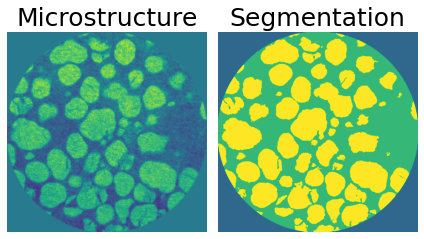

In [68]:
idx =1
whole_img = np.concatenate([np.concatenate([x[idx, 0], x[idx + 6,0]], axis=1), np.concatenate([x[idx+18,0], x[idx+12,0]], axis=1)], axis=0)
whole_binary = np.concatenate([np.concatenate([y[idx], y[idx + 6]], axis=1), np.concatenate([y[idx+18], y[idx+12]], axis=1)], axis=0)
fig, axes  = plt.subplots(ncols =2)
axes[0].axis('off')
axes[0].set_title("Microstructure", fontsize= 25)
axes[1].set_title("Segmentation", fontsize= 25)
axes[0].imshow(whole_img)
axes[1].axis('off')

axes[1].imshow(whole_binary+1, vmin =0, vmax =3)
plt.tight_layout()
fig.savefig(oj(fig_path, 'whole_img.png'))
fig.savefig(oj(fig_path, 'whole_img.pdf'))



In [67]:
(whole_binary+1).min()

1

In [199]:
# now focus on a hard part
# load a network for the full figure
fnames = sorted([oj(config['PATHS']['model_path'] , fname) for fname in os.listdir(config['PATHS']['model_path'] ) if "pkl" in fname]) 
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 

results = pd.concat(results_list, axis=1).T.infer_objects()

results.experiment_name.unique()
results['best_val_score'] = [max(x) for x in results.val_scores]
results=results[results.experiment_name == "BaselineFullDataset"]
results = results.reset_index()
net = UNet(n_channels=1, n_classes=results.num_classes[0], bilinear=results.bilinear[0]).to(device=device)
net.load_state_dict(torch.load(oj(model_path, results.iloc[0].file_name+".pt")))


<All keys matched successfully>

In [200]:
test_set = TensorDataset(
        *[
            torch.Tensor(input)
            for input in  my_data.make_dataset(
                x[-4:],
                y[-4:],
                img_size=256,
                offset=128,
            )])
test_loader = DataLoader(test_set, shuffle=False, drop_last=True, batch_size = 2)

In [201]:
# my_idxs = uncertainty_cost(net, device, test_loader, 8)

In [203]:
my_idxs = uncertainty_cost(net, device, test_loader, -1)
# my_idxs = [ 63,  49, 178,  64, 170, 179,  14, 171]


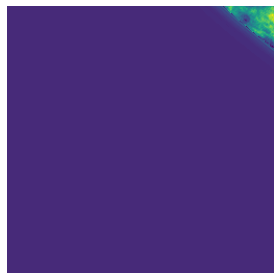

In [212]:
fig, axes = plt.subplots()
axes.imshow(test_set[my_idxs[10]][0][0])
axes.axis('off')
fig.tight_layout()
fig.savefig(oj(fig_path, 'low_uncertainty.png'))

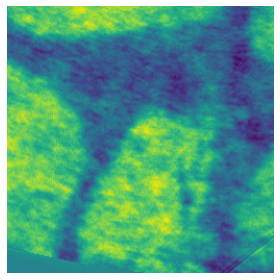

In [211]:
fig, axes = plt.subplots()
axes.imshow(test_set[my_idxs[-10]][0][0])
axes.axis('off')
fig.tight_layout()
fig.savefig(oj(fig_path, 'high_uncertainty.png'))

In [204]:
my_idxs

array([140,  91,  42, 189,  43,  35, 190, 141,  84, 182,  92, 133,  28,
        44,  21,  15,  36,   8,  14,  22,  30,   7,  29, 134,  37, 146,
       145,  77, 125, 142, 112,  45, 101,  93,  23, 108,  85,  57, 126,
       132, 135,  34, 139,   1,  56,  38, 144, 183, 109, 115,   0, 119,
       102,  78,  94, 143,  50, 191, 124, 138, 123,  16, 175,  33,  49,
       105, 116, 131, 130,  31,   4, 117, 113, 118,  12,  41,   5,  18,
        46,  25,  13, 114,  95,  27, 137,  63,   9,  70,  51, 136, 153,
        24, 122,  40, 156,   2,  86,  87,  26, 100,  98,  20, 110,  11,
       168, 127,  47,  82, 129, 103,  54,  83,  48,   3,  19,  61,   6,
       149,  69,  17,  89,  39,  64, 161,  79,  71, 107,  80, 155,  32,
        52, 181,  88,  53,  90, 179, 180,  99, 192, 152, 157, 120,  10,
       150, 184, 128, 160,  76,  81, 106, 148,  68,  96, 187,  62, 151,
       163, 162,  58, 178, 159, 111,  75, 193,  60, 186,  74, 174, 158,
       154, 121, 188, 176, 147,  67, 177, 194, 104, 164, 195, 17

In [59]:
test_set[my_idxs[idx]][1].max()

tensor(2.)

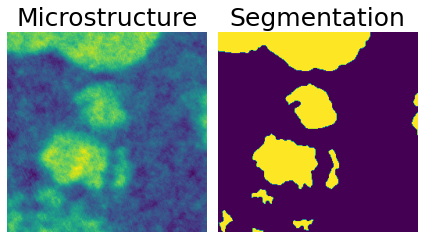

In [48]:
idx =4

fig, axes  = plt.subplots(ncols =2)
axes[0].axis('off')
axes[0].set_title("Microstructure", fontsize= 25)
axes[1].set_title("Segmentation", fontsize= 25)
axes[0].imshow(test_set[my_idxs[idx]][0][0])
axes[1].axis('off')

axes[1].imshow(test_set[my_idxs[idx]][1])
plt.tight_layout()
fig.savefig(oj(fig_path, 'part_img.png'))
fig.savefig(oj(fig_path, 'part_img.pdf'))



In [101]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

class MplColorHelper:

  def __init__(self, cmap_name, start_val, stop_val):
    self.cmap_name = cmap_name
    self.cmap = plt.get_cmap(cmap_name)
    self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
    self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

  def get_rgb(self, val):
    return self.scalarMap.to_rgba(val)
my_viridis_helper = MplColorHelper('viridis', 0, 2)
def convert_to_rgb(img):
    rgb_img = my_viridis_helper.get_rgb(img)
    rgb_img = rgb_img[:,:,:3]
    rgb_img[annot_img== 255] = [.7,.7,.7]
    return rgb_img[:,:,:3]
        

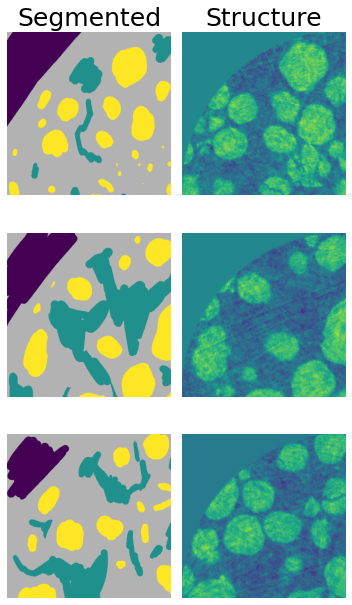

In [125]:
# make image of the rough annotation
x, y, _, _ = my_data.load_layer_data(
        oj(config["DATASET"]["data_path"], 'lno_halfHour')
    )

x = (x - data_min) / (data_max - data_min)
idx =7

fig, axes  = plt.subplots(ncols =2, nrows =3, figsize = (5,9))
for i in range(3):
    axes[i,0].axis('off')
    axes[i,1].axis('off')
    axes[0,1].set_title("Structure", fontsize= 25, )
    axes[0,0].set_title("Segmented", fontsize= 25,)
    axes[i,1].imshow(x[idx+i][0])
    
    annot_img = y[idx+i]
    # annot_img[annot_img == 255] = 10
    axes[i,0].imshow(convert_to_rgb(annot_img,))
plt.tight_layout()
fig.savefig(oj(fig_path, 'rough.png'))
fig.savefig(oj(fig_path, 'rough.pdf'))



In [126]:
# image of the unlabeled

# create network reading in etc|

In [ ]:
def load_imgs(path):
    """ load all the images in the current folder"""
    imgs = []
    for fname in sorted(os.listdir(path)):
        if ".tif" in fname:
            
            imgs.append(io.imread(oj(path, fname)))
    
    return np.asarray(imgs)

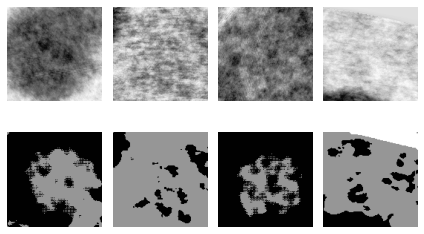

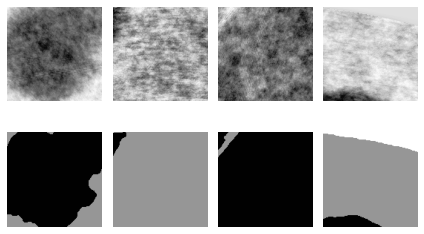

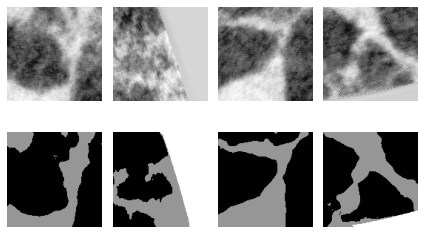

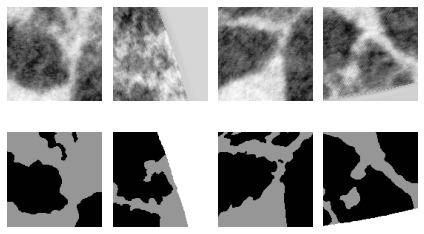

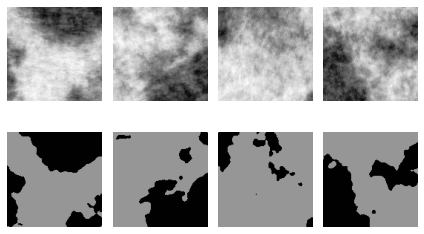

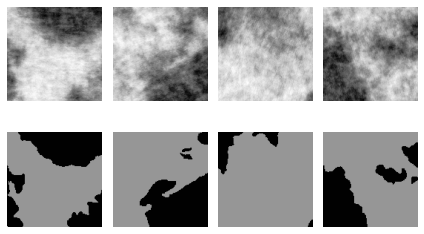

In [198]:
folder_name = '6307559837'
for cur_iteration_id in [0, 5, 15]:

    full_name = oj(config["PATHS"]["progress_results"], folder_name, f"{cur_iteration_id:01d}")
    human_annotated= load_imgs(oj(full_name,"human_annotated"))
    model_annotated = load_imgs(oj(full_name,"predictions"))
    input_imgs = load_imgs(oj(full_name,"images"))
    fig, axes = plt.subplots(ncols =4 , nrows=2)
    for i in range(4):
        axes[0,i].imshow(input_imgs[i],cmap = plt.get_cmap('Greys'))
        axes[0,i].axis('off')
        axes[1,i].imshow(model_annotated[i], vmin = 0, vmax = .67,cmap = plt.get_cmap('Greys'))
        axes[1,i].axis('off')
    fig.tight_layout()
    fig.savefig(oj(fig_path, 'model_prediction_{}.png').format(cur_iteration_id))
    fig, axes = plt.subplots(ncols =4 , nrows=2)
    for i in range(4):
        axes[0,i].imshow(input_imgs[i],cmap = plt.get_cmap('Greys'))
        axes[0,i].axis('off')
        axes[1,i].imshow(human_annotated[i], vmin = 0, vmax = .67,cmap = plt.get_cmap('Greys'))
        axes[1,i].axis('off')
    fig.tight_layout()
    fig.savefig(oj(fig_path, 'human_prediction_{}.png').format(cur_iteration_id))

In [174]:
test_imgs = load_imgs(oj(full_name,"human_annotated"))

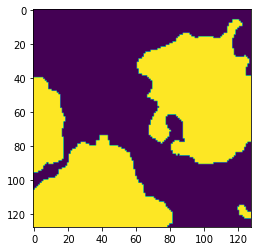

In [175]:
plt.imshow(test_imgs[0])

In [171]:
test_imgs[0][:,:,3].min()

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

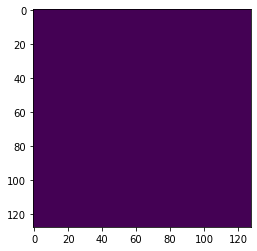

In [160]:
plt.imshow(test_imgs[0][:,:,3])

In [135]:
full_name

'C:\\Users\\lauri\\Documents\\GitHub\\segmenter\\data\\6307559837\\10'

In [ ]:
complete_folder_name = 

# make barplot

In [2]:
fnames = sorted([oj(config['PATHS']['model_path'] , fname) for fname in os.listdir(config['PATHS']['model_path'] ) if "pkl" in fname]) 
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 

results = pd.concat(results_list, axis=1).T.infer_objects()

results.experiment_name.unique()
results['best_val_score'] = [max(x) for x in results.val_scores]
# results_baseline 

results[['foldername',  'final_dice_score','cost_function', 'add_ratio','experiment_name']].groupby([ 'experiment_name','foldername','add_ratio',  'cost_function']).mean()

final_dice_score
experiment_name      foldername   add_ratio cost_function                     
00Aquisition         lno_halfHour 0.02      uncertainty_cost              0.91
                                  0.05      uncertainty_cost              0.92
                                  0.25      uncertainty_cost              0.95
01Aquisition         lno_halfHour 0.02      random_cost                   0.90
                                            uncertainty_cost              0.91
                                  0.05      random_cost                   0.84
                                            uncertainty_cost              0.92
BaselineFullDataset  lno          0.00      uncertainty_cost              0.96
BaselineNoAquisition lno_halfHour 0.00      random_cost                   0.81

In [35]:
results_dict = {"Baseline": .81 , "Human" : .97, "NN": .96,  "AL": .92, "Random": 0.84}
sparse_results = {"Baseline": .81 , "Human" : .97, "NN": .96,  "Active learning": .92, }

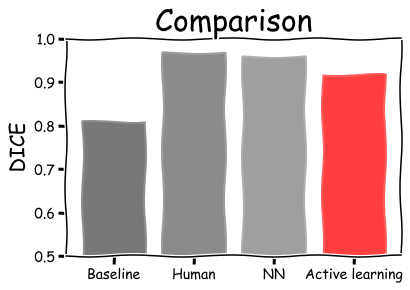

In [36]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from os.path import join as oj
with plt.xkcd():
    objects = list(sparse_results.keys())
    colors = cm.tab10(np.linspace(0, 1, len(objects)))
    colors = [(0.3, 0.3, 0.3), (0.4, 0.4, 0.4), (0.5, .5, 0.5), (1, 0, 0)]
    performance = list(sparse_results.values())
    fig, axes = plt.subplots()

    axes.bar(objects, performance, color = colors, align='center', alpha=0.5)
    plt.ylabel('DICE', fontsize = 20)
    # plt.xlabel('Method', )
    plt.title('Comparison', fontsize = 30)
    plt.ylim(.5, 1)

    plt.show()
    fig.tight_layout()
    fig.savefig(oj(fig_path, 'comparison.png'))
    fig.savefig(oj(fig_path, 'comparison.pdf'))


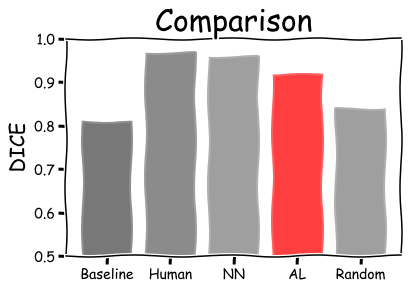

In [37]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from os.path import join as oj
with plt.xkcd():
    objects = list(results_dict.keys())
    colors = cm.tab10(np.linspace(0, 1, len(objects)))
    colors = [(0.3, 0.3, 0.3), (0.4, 0.4, 0.4), (0.5, .5, 0.5), (1, 0, 0),(0.5, .5, 0.5),]
    performance = list(results_dict.values())
    fig, axes = plt.subplots()

    axes.bar(objects, performance, color = colors, align='center', alpha=0.5)
    plt.ylabel('DICE', fontsize = 20)
    # plt.xlabel('Method', )
    plt.title('Comparison', fontsize = 30)
    plt.ylim(.5, 1)

    plt.show()
    fig.tight_layout()
    fig.savefig(oj(fig_path, 'comparison_long.png'))
    fig.savefig(oj(fig_path, 'comparison_long.pdf'))


Load an NN

In [36]:
progress_path =config['PATHS']['progress_results'] 
my_id ='8273825689'
my_path = oj(progress_path, my_id, '19','human_annotated' )

In [46]:
# load tif file as numpy array
from PIL import Image
img = io.imread(oj(my_path, '2.tif'))
img = img.astype(np.float32) /3

In [47]:
Image.fromarray(img).save(
    oj(my_path, str('test') + ".tif"),
)

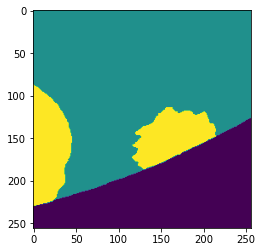

In [42]:
plt.imshow(img)

In [44]:
img.dtype

dtype('uint8')

['1428051558',
 '3232408470',
 '5437594334',
 '6540258282',
 '7452428011',
 '8161724924',
 '9037947055',
 '9097561471',
 '9734152742']

In [2]:
fnames = sorted([oj(config['PATHS']['model_path'] , fname) for fname in os.listdir(config['PATHS']['model_path'] ) if "pkl" in fname]) 
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 

results = pd.concat(results_list, axis=1).T.infer_objects()

results.experiment_name.unique()
results['best_val_score'] = [max(x) for x in results.val_scores]
results[['foldername',  'final_dice_score','cost_function', 'add_ratio','experiment_name']].groupby([ 'experiment_name', 'cost_function','foldername','add_ratio', ]).count()

final_dice_score
experiment_name             cost_function    foldername   add_ratio                  
09deepcopy                  random_cost      lno_halfHour 0.05                      3
                            uncertainty_cost lno_halfHour 0.05                      1
11entropy                   random_cost      lno_halfHour 0.05                      3
                            uncertainty_cost lno_halfHour 0.05                      3
12largeSamples              random_cost      lno_halfHour 0.05                      3
                            uncertainty_cost lno_halfHour 0.05                      3
RealValBaselineNoAquisition random_cost      lno_halfHour 0.00                      5
TestPresentation            random_cost      lno_halfHour 0.02                      2
                            uncertainty_cost lno_halfHour 0.02                      2
TestPresentationLargeSample random_cost      lno_halfHour 0.02                      1
                            uncertainty_cost lno_halfHour 0.02                      1

In [15]:
results = results[results.experiment_name == '07comparisonRealValNewLoader']
results = results[results.add_ratio	 == .02]
results = results.reset_index()

In [16]:
results

,index,file_name,epochs,batch_size,cost_function,add_ratio,foldername,poolname,experiment_name,lr,...,seed,scale,val,amp,bilinear,classes,val_scores,num_classes,final_dice_score,best_val_score
0,11,2399515781,250,128,uncertainty_cost,0.02,lno_halfHour,lno,07comparisonRealValNewLoader,0.00,...,1,0.50,10,False,False,6,"[0.5002429485321045, 0.7847887873649597, 0.429...",3,0.83,0.88
1,12,2797635714,250,128,random_cost,0.02,lno_halfHour,lno,07comparisonRealValNewLoader,0.00,...,2,0.50,10,False,False,6,"[0.35466906428337097, 0.6250970363616943, 0.64...",3,0.89,0.89
2,21,3850507977,250,128,random_cost,0.02,lno_halfHour,lno,07comparisonRealValNewLoader,0.00,...,0,0.50,10,False,False,6,"[0.3602927625179291, 0.6549596190452576, 0.640...",3,0.73,0.89
3,26,4686223636,250,128,random_cost,0.02,lno_halfHour,lno,07comparisonRealValNewLoader,0.00,...,1,0.50,10,False,False,6,"[0.4613177478313446, 0.7334321737289429, 0.798...",3,0.85,0.85
4,37,7221024133,250,128,uncertainty_cost,0.02,lno_halfHour,lno,07comparisonRealValNewLoader,0.00,...,0,0.50,10,False,False,6,"[0.33328503370285034, 0.5451355576515198, 0.71...",3,0.87,0.88
5,40,8255682498,250,128,uncertainty_cost,0.02,lno_halfHour,lno,07comparisonRealValNewLoader,0.00,...,2,0.50,10,False,False,6,"[0.3169001042842865, 0.6730227470397949, 0.748...",3,0.88,0.88


In [18]:
results.final_dice_score[0]

0.8326637148857117

In [19]:
results.val_scores[0][-1]

0.8326637148857117

In [51]:
best_idx =results.best_val_score.argmax()


In [52]:
net = UNet(1, results.num_classes[best_idx], bilinear = results.bilinear[best_idx]).to(device)
# my_models = [UNet(1, 3, bilinear = results_all.bilinear[0]).to(device) for i, _ in enumerate(results.file_name)] 

net.load_state_dict(torch.load(oj(config['PATHS']['model_path'] ,results.file_name[best_idx]+".pt")))
net = net.to(device).eval()

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
results.foldername[best_idx]

'lno_halfHour'

In [53]:
x,y,num_classes,_ = my_data.load_layer_data(oj(data_path, 'lno'))

x, y = x[:-4], y[:-4]  # just don't touch the last four
x = x/x.max()
val_percent = .25
init_train_ratio =1
image_size = 128
offset = 64
all_idxs = np.arange(len(x))
np.random.seed(0)
np.random.shuffle(all_idxs)
n_val = np.maximum(int(len(x) * val_percent), 1)
n_train = len(x) - n_val
all_train_idxs = all_idxs[:n_train]
val_idxs = all_idxs[n_train:]
init_train_idxs = all_train_idxs[: np.maximum(1, int(init_train_ratio * n_train))]
pool_idxs = all_train_idxs[np.maximum(1, int(init_train_ratio * n_train)) :]



In [14]:
# finding out how many images are in the pool
test_dataset = my_data.make_dataset_single(
        x_pool[pool_ids_init],
        img_size=args.image_size,
        offset=args.image_size,
    )[0]

(20, 1, 1024, 1024)

In [18]:
img_idx = 2
test_img_np  = ((x[val_idxs[img_idx]][None, ].astype(np.float32) ))
with torch.no_grad():
    img_t = torch.Tensor(test_img_np).to(device)
    output = net.forward(img_t).cpu().detach().numpy()[0]

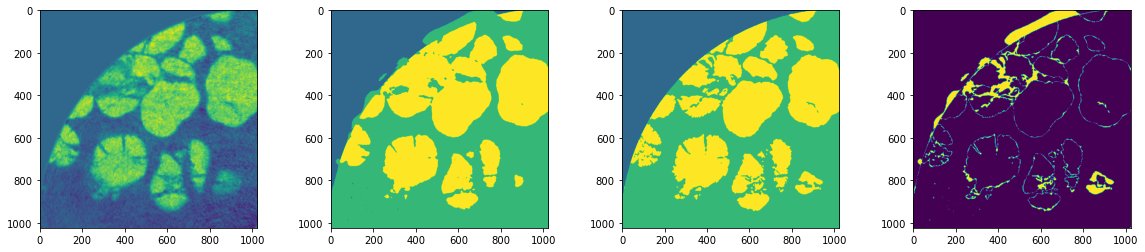

In [19]:
fig, axes = plt.subplots(ncols = 4, figsize = (20,4))
axes[0].imshow(x[val_idxs[img_idx]][0])
axes[1].imshow(np.argmax(output, axis=0),vmin =-1, vmax = 2)
target = np.copy(y[val_idxs[img_idx]]).astype(np.int16)
target[np.where(target == 255)] =-1
axes[2].imshow(target, vmin =-1,vmax = 2)
axes[3].imshow((target !=np.argmax(output, axis=0) ) * (target !=-1))
# axes[1].imshow()

# try with detailed

In [39]:
x,y,num_classes,_ = my_data.load_layer_data(oj(data_path, 'lno'))

x, y = x[:-4], y[:-4]  # just don't touch the last four
x = x/x.max()
val_percent = .25
init_train_ratio =1
image_size = 128
offset = 64
all_idxs = np.arange(len(x))
np.random.seed(0)
np.random.shuffle(all_idxs)
n_val = np.maximum(int(len(x) * val_percent), 1)
n_train = len(x) - n_val
all_train_idxs = all_idxs[:n_train]
val_idxs = all_idxs[n_train:]
init_train_idxs = all_train_idxs[: np.maximum(1, int(init_train_ratio * n_train))]
pool_idxs = all_train_idxs[np.maximum(1, int(init_train_ratio * n_train)) :]

val_set = TensorDataset(
    *[
        torch.Tensor(input)
        for input in my_data.make_dataset(
            x[val_idxs[:1]],
            y[val_idxs[:1]],
            img_size=image_size,
            offset=image_size,
        )
    ]
)
val_loader = DataLoader(val_set, shuffle=False, drop_last=False, batch_size = 16)

In [40]:
val_loader.batch_size

16

In [40]:
x_small, _,=my_data.make_dataset(
            x[val_idxs[:1]],
            y[val_idxs[:1]],
            img_size=image_size,
            offset=image_size,
        )

In [44]:
x_small[test_idxes].min()

0.23921568627450981

In [ ]:
net(t)

In [38]:
x.shape

(20, 1, 1024, 1024)

In [ ]:
val_loader

In [56]:
net

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [ ]:
len(all_train_idxs)

In [ ]:
len(val_loader.dataset)

In [ ]:
plt.imshow(x[val_idxs[0]][0])

In [ ]:
test_ids_safe = std_cost_function(net, device,val_loader,n_choose =59)

# test_ids = np.argsort(test_ids_safe)

In [ ]:
len(val_loader.dataset)

In [ ]:
test_ids_safe

In [ ]:
plt.imshow(val_set[test_ids_safe[0]][0][0])

In [ ]:
plt.imshow(val_set[test_ids_safe[-20]][0][0])

In [ ]:
test_ids_safe[32]

In [ ]:
test_ids_safe[23]

In [ ]:
test_ids_safe

In [ ]:
test_ids_safe

In [ ]:
test_ids_safe

In [ ]:
test_ids_safe

In [ ]:
test_ids_safe

In [ ]:
net(val_set[test_ids_safe[1]][0][None,:].to(device))[0].std(dim=1).mean(dim=(0,1))

In [ ]:
net(val_set[test_ids_safe[-1]][0][None,:].to(device))[0].std(dim=1).mean(dim=(0,1))

In [ ]:
net(val_set[test_ids_safe[-1]][0][None,:].to(device))[0][0].mean()

In [ ]:
net(val_set[test_ids_safe[-1]][0][None,:].to(device))[0][2].mean()

In [ ]:
net(val_set[test_ids_safe[-1]][0][None,:].to(device))[0].std(dim=1)

In [ ]:
test_ids_safe[224]

In [ ]:
len(test_ids_safe)

In [ ]:
test_ids = np.sort(test_ids)

In [ ]:
plt.imshow(val_set[5][0][0])

In [ ]:
plt.imshow(val_set[test_ids[10]][0][0])

In [ ]:
plt.imshow(val_set[test_ids[1]][0][0])

In [ ]:
plt.imshow(val_set[test_ids[0]][0][0])

In [ ]:
img_idx = 0
test_img_np  = ((x[img_idx][None, ].astype(np.float32) ))
with torch.no_grad():
    img_t = torch.Tensor(test_img_np).to(device)
    output = F.softmax(net.forward(img_t)[0], dim =0).cpu().detach().numpy()


In [ ]:
fig, axes = plt.subplots(ncols = 5, figsize = (20,4))
axes[0].imshow(x[img_idx][0])
axes[1].imshow(np.argmax(output, axis=0),vmin =-1, vmax = 2)
target = np.copy(y[img_idx]).astype(np.int16)
target[np.where(target == 255)] =-1
axes[2].imshow(target, vmin =-1,vmax = 2)
axes[3].imshow((target !=np.argmax(output, axis=0) ))
max_val =np.quantile(output.std(axis=0).max() - output.std(axis=0),.90)
axes[4].imshow(output.std(axis=0).max() - output.std(axis=0),vmax = max_val)
# axes[1].imshow()

In [ ]:
output.std(axis=0).max() - output.std(axis=0)

In [ ]:
with torch.no_grad():
    img_t = torch.Tensor(x[val_idxs]).to(device)
    output = F.softmax(net.forward(img_t), dim =1)


In [ ]:
(torch.argmax(output, dim = 1).detach().cpu().numpy() ==y[val_idxs]).mean()

In [ ]:
(torch.argmax(output, dim = 1).detach().cpu().numpy() ==y[val_idxs])[np.where((my_std < np.quantile(my_std, .1)))].mean()

In [ ]:
(torch.argmax(output, dim = 1).detach().cpu().numpy() ==y[val_idxs])[np.where((my_std > np.quantile(my_std, .1)))].mean()

In [ ]:
len(val_loader)

In [ ]:
val_loader

In [ ]:
eva

In [ ]:
my_std = torch.std(output,dim =1).detach().cpu().numpy()

In [ ]:
torch.argmax(output, dim = 1)

In [ ]:
np.where((my_std < np.quantile(my_std, .1)))

In [ ]:
(torch.argmax(output, dim = 1).detach().cpu().numpy() ==y[val_idxs]).mean()

In [ ]:
output.shape

In [ ]:
1-dice_loss(output, torch.Tensor(y[val_idxs]).to(device), num_classes, multiclass=True)

In [ ]:
from dice_score import dice_loss

In [ ]:
dice_loss()

In [ ]:
num_classes

In [ ]:
np.quantile(output.std(axis=0).max() - output.std(axis=0), .9)

In [ ]:
output.std(axis=0).max()

In [ ]:
(target ==np.argmax(output, axis=0) ).mean()

In [ ]:
output.std(axis=0)

# old stuff

In [ ]:
for i in range(4):
    img_idx = i
    test_img_np  = ((x[img_idx][None, ].astype(np.float32) ))
    with torch.no_grad():
        img_t = torch.Tensor(test_img_np).to(device)
        output = net.forward(img_t).cpu().detach().numpy()[0]
        show_img = np.zeros_like(y[img_idx])
        show_img[np.where(y[img_idx] ==my_data.phase_1)] =1
        show_img[np.where(y[img_idx] ==my_data.phase_2)] =2
        print((show_img ==np.argmax(output, axis=0)).mean())


In [ ]:
img_idx = -1
test_img_np  = ((x[img_idx][None, ].astype(np.float32) -my_data.mean)/my_data.std)
with torch.no_grad():
    img_t = torch.Tensor(test_img_np).to(device)
    output = net.forward(img_t).cpu().detach().numpy()[0]


In [ ]:
show_img = np.zeros_like(y[img_idx])
show_img[np.where(y[img_idx] ==my_data.phase_1)] =1
show_img[np.where(y[img_idx] ==my_data.phase_2)] =2

In [ ]:
std_large = output.std(axis=0)<np.quantile(output.std(axis=0), .1)

fig, axes = plt.subplots(ncols = 5, figsize = (20,7))
axes[0].imshow(x[img_idx,2])
axes[1].imshow(np.argmax(output, axis=0))
axes[2].imshow(show_img)
axes[3].imshow(show_img !=np.argmax(output, axis=0) )

axes[4].imshow(std_large)

In [ ]:
x.shape

In [ ]:
std_large = output.std(axis=0)<np.quantile(output.std(axis=0), .05)

fig, axes = plt.subplots(ncols = 3, figsize = (20,8))
# axes[0].imshow(x[img_idx,2])
axes[0].imshow(np.argmax(output, axis=0))
# axes[2].imshow(show_img)
axes[1].imshow(show_img !=np.argmax(output, axis=0) )

axes[2].imshow(std_large)

In [ ]:
(show_img !=np.argmax(output, axis=0))[np.where(1-std_large)].mean()

In [ ]:
(show_img ==np.argmax(output, axis=0)).mean()

In [ ]:
correct = np.reshape(show_img !=np.argmax(output, axis=0),-1)
std = np.reshape(output.std(axis=0), -1)

In [ ]:
std_large = output.std(axis=0)<np.quantile(output.std(axis=0), .1)

fig, axes = plt.subplots(ncols = 5, figsize = (20,7))
axes[0].imshow(x[img_idx,2])
axes[1].imshow(np.argmax(output, axis=0))
axes[2].imshow(show_img)
axes[3].imshow(show_img !=np.argmax(output, axis=0) )

axes[4].imshow(std_large)

In [ ]:
std_large = output.std(axis=0)<np.quantile(output.std(axis=0), .1)

fig, axes = plt.subplots(ncols = 1, figsize = (20,7))
axes.imshow(x[img_idx,2][200:400,350:600])

# axes[4].imshow(std_large)

In [ ]:
x.shape

In [ ]:
plt.imshow(x[0,2])

In [ ]:
plt.imshow(x[-1,2])

In [ ]:
x[img_idx,2][200:400,350:600]